In [23]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [24]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [25]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


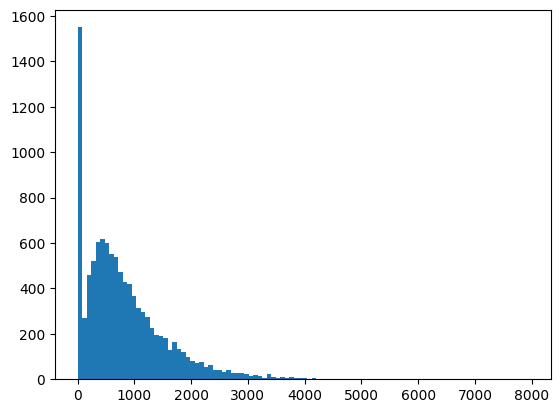

In [26]:
from matplotlib import pyplot as plt
from torch_geometric.utils import  degree
# plt.hist(degree(dataset.edge_index[0]), bins=100);

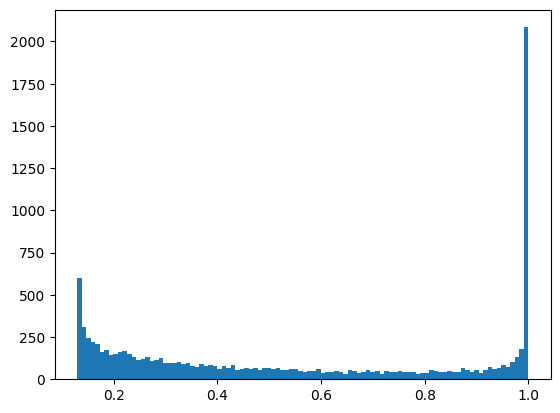

In [27]:
plt.hist(dataset.x[:, 0], bins=100);

In [28]:
dataset.num_features
# try implement this
# dataset.num_nodes

1

In [29]:
import copy
import os.path as osp
import time

import torch
import torch.nn.functional as F
from tqdm import tqdm

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device, 'x', 'y', 'train_mask', 'val_mask', 'test_mask')

In [30]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score
import numpy as np

kwargs = {'batch_size': 256, 'num_workers': 4, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[50], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        # self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                # x = F.dropout(x, p=0.5, training=self.training)
            # x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                # x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.binary_cross_entropy_with_logits(y_hat.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        # total_loss += float(loss) * batch.batch_size
        # total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples

train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)
    

@torch.no_grad()
def test():
    model.eval()
    logits = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)
    # binary prediction
    y_pred = torch.where(y_pred_prob > 0.5, 1, 0)
    # create hard label only for confidence proteins
    y_hard = torch.where(data.y > 0.99, 1, 
                         torch.where(data.y < 0.5, 0, -1))
    binary_mask = (y_hard != -1).bool()
    y_hard = y_hard.to(y_pred_prob.device)
    y = data.y.to(y_pred_prob.device)


    loss = []
    train_tracker.update(y_pred_prob[data.train_mask], y_hard[data.train_mask])
    val_tracker.update(y_pred_prob[data.val_mask], y_hard[data.val_mask])
    test_tracker.update(y_pred_prob[data.test_mask], y_hard[data.test_mask])
    
    # for mask in [data.train_mask, data.val_mask, data.test_mask]:
    #     mask = mask & binary_mask
    #     tracker.update(y_pred_prob[mask], y_hard[mask])
    #     loss.append(F.binary_cross_entropy_with_logits(logits[mask], y[mask]))
    
    return loss

In [31]:

times = []
for epoch in range(1, 11):
    start = time.time()
    loss, acc = train(epoch)
    # print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_loss, val_loss, test_loss = test()
    
    train_tracker.compute()
    val_tracker.compute()
    test_tracker.compute()
    
    # print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
    #       f'Test Loss: {test_loss:.4f}')
    print(f'Epoch: {epoch:02d}, Train Acc: {train_tracker["BinaryAccuracy"]:.4f}, Val Acc: {val_tracker["BinaryAccuracy"]:.4f}, '
          f'Test AUC: {test_tracker["BinaryAccuracy"]:.4f}')
    # print(f'Epoch: {epoch:02d}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, '
    #       f'Test AUC: {test_auc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Evaluating: 100%|██████████| 10503/10503 [00:05<00:00, 1844.10it/s]


Epoch: 01, Train Loss: 0.7679, Val Loss: 0.7665, Test Loss: 0.7683
Epoch: 01, Train Acc: 0.2197, Val Acc: 0.2302, Test Acc: 0.2142
Epoch: 01, Train AUC: 0.1527, Val AUC: 0.1676, Test AUC: 0.1414
Epoch: 01, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 01: 100%|██████████| 8403/8403 [00:04<00:00, 1894.10it/s]


Epoch 01, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24846.95it/s]


Epoch: 02, Train Loss: 0.5929, Val Loss: 0.5953, Test Loss: 0.5922
Epoch: 02, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 02, Train AUC: 0.8471, Val AUC: 0.8324, Test AUC: 0.8594
Epoch: 02, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 02: 100%|██████████| 8403/8403 [00:00<00:00, 34397.19it/s]


Epoch 02, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 25079.92it/s]


Epoch: 03, Train Loss: 0.4947, Val Loss: 0.5012, Test Loss: 0.4929
Epoch: 03, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 03, Train AUC: 0.8471, Val AUC: 0.8325, Test AUC: 0.8593
Epoch: 03, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 03: 100%|██████████| 8403/8403 [00:00<00:00, 35449.85it/s]


Epoch 03, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 22388.16it/s]


Epoch: 04, Train Loss: 0.4608, Val Loss: 0.4706, Test Loss: 0.4582
Epoch: 04, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 04, Train AUC: 0.8471, Val AUC: 0.8324, Test AUC: 0.8602
Epoch: 04, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 04: 100%|██████████| 8403/8403 [00:00<00:00, 37242.38it/s]


Epoch 04, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 14358.54it/s]


Epoch: 05, Train Loss: 0.4533, Val Loss: 0.4648, Test Loss: 0.4502
Epoch: 05, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 05, Train AUC: 0.8472, Val AUC: 0.8332, Test AUC: 0.8603
Epoch: 05, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 05: 100%|██████████| 8403/8403 [00:00<00:00, 37484.63it/s]


Epoch 05, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 13920.68it/s]


Epoch: 06, Train Loss: 0.4505, Val Loss: 0.4625, Test Loss: 0.4470
Epoch: 06, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 06, Train AUC: 0.8467, Val AUC: 0.8345, Test AUC: 0.8621
Epoch: 06, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 06: 100%|██████████| 8403/8403 [00:00<00:00, 36520.32it/s]


Epoch 06, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 23607.82it/s]


Epoch: 07, Train Loss: 0.4481, Val Loss: 0.4604, Test Loss: 0.4444
Epoch: 07, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 07, Train AUC: 0.8460, Val AUC: 0.8356, Test AUC: 0.8626
Epoch: 07, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 07: 100%|██████████| 8403/8403 [00:00<00:00, 37740.48it/s]


Epoch 07, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 25461.44it/s]


Epoch: 08, Train Loss: 0.4459, Val Loss: 0.4582, Test Loss: 0.4419
Epoch: 08, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 08, Train AUC: 0.8456, Val AUC: 0.8359, Test AUC: 0.8622
Epoch: 08, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 08: 100%|██████████| 8403/8403 [00:00<00:00, 38636.82it/s]


Epoch 08, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24507.99it/s]


Epoch: 09, Train Loss: 0.4438, Val Loss: 0.4561, Test Loss: 0.4396
Epoch: 09, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 09, Train AUC: 0.8451, Val AUC: 0.8358, Test AUC: 0.8626
Epoch: 09, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 09: 100%|██████████| 8403/8403 [00:00<00:00, 39465.67it/s]


Epoch 09, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 23782.19it/s]


Epoch: 10, Train Loss: 0.4418, Val Loss: 0.4543, Test Loss: 0.4375
Epoch: 10, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 10, Train AUC: 0.8447, Val AUC: 0.8360, Test AUC: 0.8625
Epoch: 10, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 10: 100%|██████████| 8403/8403 [00:00<00:00, 36764.16it/s]


Epoch 10, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24409.73it/s]


Epoch: 11, Train Loss: 0.4401, Val Loss: 0.4526, Test Loss: 0.4355
Epoch: 11, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 11, Train AUC: 0.8443, Val AUC: 0.8359, Test AUC: 0.8620
Epoch: 11, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 11: 100%|██████████| 8403/8403 [00:00<00:00, 36593.50it/s]


Epoch 11, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 23541.83it/s]


Epoch: 12, Train Loss: 0.4384, Val Loss: 0.4509, Test Loss: 0.4336
Epoch: 12, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 12, Train AUC: 0.8438, Val AUC: 0.8363, Test AUC: 0.8621
Epoch: 12, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 12: 100%|██████████| 8403/8403 [00:00<00:00, 38520.94it/s]


Epoch 12, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24702.90it/s]


Epoch: 13, Train Loss: 0.4370, Val Loss: 0.4496, Test Loss: 0.4320
Epoch: 13, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 13, Train AUC: 0.8435, Val AUC: 0.8366, Test AUC: 0.8623
Epoch: 13, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 13: 100%|██████████| 8403/8403 [00:00<00:00, 36762.71it/s]


Epoch 13, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24991.72it/s]


Epoch: 14, Train Loss: 0.4357, Val Loss: 0.4483, Test Loss: 0.4305
Epoch: 14, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 14, Train AUC: 0.8432, Val AUC: 0.8366, Test AUC: 0.8623
Epoch: 14, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 14: 100%|██████████| 8403/8403 [00:00<00:00, 39104.99it/s]


Epoch 14, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24593.80it/s]


Epoch: 15, Train Loss: 0.4345, Val Loss: 0.4471, Test Loss: 0.4291
Epoch: 15, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 15, Train AUC: 0.8430, Val AUC: 0.8364, Test AUC: 0.8624
Epoch: 15, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 15: 100%|██████████| 8403/8403 [00:00<00:00, 39290.04it/s]


Epoch 15, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24030.90it/s]


Epoch: 16, Train Loss: 0.4336, Val Loss: 0.4462, Test Loss: 0.4280
Epoch: 16, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 16, Train AUC: 0.8429, Val AUC: 0.8364, Test AUC: 0.8622
Epoch: 16, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 16: 100%|██████████| 8403/8403 [00:00<00:00, 35227.09it/s]


Epoch 16, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24046.48it/s]


Epoch: 17, Train Loss: 0.4327, Val Loss: 0.4456, Test Loss: 0.4270
Epoch: 17, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 17, Train AUC: 0.8428, Val AUC: 0.8364, Test AUC: 0.8620
Epoch: 17, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 17: 100%|██████████| 8403/8403 [00:00<00:00, 39547.99it/s]


Epoch 17, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 25211.23it/s]


Epoch: 18, Train Loss: 0.4321, Val Loss: 0.4448, Test Loss: 0.4262
Epoch: 18, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 18, Train AUC: 0.8426, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 18, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 18: 100%|██████████| 8403/8403 [00:00<00:00, 38696.76it/s]


Epoch 18, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24761.35it/s]


Epoch: 19, Train Loss: 0.4315, Val Loss: 0.4446, Test Loss: 0.4254
Epoch: 19, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 19, Train AUC: 0.8426, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 19, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 19: 100%|██████████| 8403/8403 [00:00<00:00, 36397.74it/s]


Epoch 19, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24120.15it/s]


Epoch: 20, Train Loss: 0.4311, Val Loss: 0.4444, Test Loss: 0.4249
Epoch: 20, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 20, Train AUC: 0.8426, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 20, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 20: 100%|██████████| 8403/8403 [00:00<00:00, 38953.46it/s]


Epoch 20, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 23989.97it/s]


Epoch: 21, Train Loss: 0.4307, Val Loss: 0.4439, Test Loss: 0.4244
Epoch: 21, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 21, Train AUC: 0.8426, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 21, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 21: 100%|██████████| 8403/8403 [00:00<00:00, 36785.23it/s]


Epoch 21, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 23035.72it/s]


Epoch: 22, Train Loss: 0.4304, Val Loss: 0.4436, Test Loss: 0.4241
Epoch: 22, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 22, Train AUC: 0.8425, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 22, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 22: 100%|██████████| 8403/8403 [00:00<00:00, 36522.10it/s]


Epoch 22, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 25095.16it/s]


Epoch: 23, Train Loss: 0.4303, Val Loss: 0.4434, Test Loss: 0.4238
Epoch: 23, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 23, Train AUC: 0.8425, Val AUC: 0.8365, Test AUC: 0.8619
Epoch: 23, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 23: 100%|██████████| 8403/8403 [00:00<00:00, 39020.86it/s]


Epoch 23, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24405.37it/s]


Epoch: 24, Train Loss: 0.4301, Val Loss: 0.4436, Test Loss: 0.4235
Epoch: 24, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 24, Train AUC: 0.8427, Val AUC: 0.8364, Test AUC: 0.8620
Epoch: 24, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 24: 100%|██████████| 8403/8403 [00:00<00:00, 37516.75it/s]


Epoch 24, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 24213.59it/s]


Epoch: 25, Train Loss: 0.4300, Val Loss: 0.4435, Test Loss: 0.4234
Epoch: 25, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 25, Train AUC: 0.8427, Val AUC: 0.8364, Test AUC: 0.8620
Epoch: 25, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 25: 100%|██████████| 8403/8403 [00:00<00:00, 36986.93it/s]


Epoch 25, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 21342.10it/s]


Epoch: 26, Train Loss: 0.4299, Val Loss: 0.4432, Test Loss: 0.4233
Epoch: 26, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 26, Train AUC: 0.8428, Val AUC: 0.8364, Test AUC: 0.8620
Epoch: 26, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 26: 100%|██████████| 8403/8403 [00:00<00:00, 35677.72it/s]


Epoch 26, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 22682.31it/s]


Epoch: 27, Train Loss: 0.4298, Val Loss: 0.4436, Test Loss: 0.4231
Epoch: 27, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 27, Train AUC: 0.8430, Val AUC: 0.8365, Test AUC: 0.8622
Epoch: 27, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 27: 100%|██████████| 8403/8403 [00:00<00:00, 37032.64it/s]


Epoch 27, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 21105.33it/s]


Epoch: 28, Train Loss: 0.4298, Val Loss: 0.4437, Test Loss: 0.4230
Epoch: 28, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 28, Train AUC: 0.8431, Val AUC: 0.8364, Test AUC: 0.8624
Epoch: 28, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 28: 100%|██████████| 8403/8403 [00:00<00:00, 29405.09it/s]


Epoch 28, Loss: 0.0000


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 21333.21it/s]


Epoch: 29, Train Loss: 0.4297, Val Loss: 0.4434, Test Loss: 0.4230
Epoch: 29, Train Acc: 0.7803, Val Acc: 0.7698, Test Acc: 0.7858
Epoch: 29, Train AUC: 0.8431, Val AUC: 0.8364, Test AUC: 0.8624
Epoch: 29, Train F1: 0.8766, Val F1: 0.8699, Test F1: 0.8801


Epoch 29: 100%|██████████| 8403/8403 [00:00<00:00, 34575.73it/s]

Epoch 29, Loss: 0.0000
Median time per epoch: 0.6855s


({'BinaryAccuracy': 0.7858197689056396,
  'BinaryAUROC': 0.8626264929771423,
  'BinaryF1Score': 0.8800661563873291},
 {'BinaryAccuracy': 1, 'BinaryAUROC': 6, 'BinaryF1Score': 1})

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Step', ylabel='MetricTracker'>)

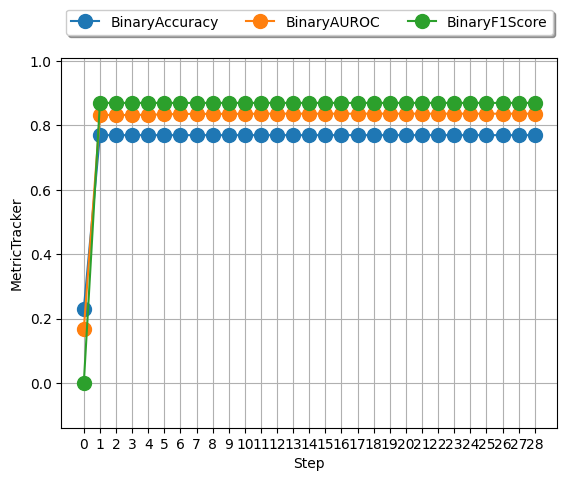